# Introduction
The goal of this notebook is to train a model using the x-ray images of lungs to see if healthy or infected lungs can be identified. Restricted Boltzmann Machine(RBM) will be used to model the data. The following will be discussed and applied below. 
    1. Import the Images
    2. Split the Data Between Train/Test
    3. Model the Data

## Import the Data
The data was obtained from kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. The dataset contains over 6000 X-rays. Due to the memory restrictions of the machine used to model and the time constraints, only 800 images were utilized for the purpose of this excercise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize
from skimage.io import imshow

%matplotlib inline

In [2]:
def load_lungs(data_path, categories, img_size):
    """Build dataset of x-rays
    
    Parameters:
    data_path(str): file location
    categories(str): folders within file location
    img_size(int): dimensions of image
    
    Returns:
    Tuple of the data and targets
    """
    data = []
    
    for category in categories:
        #path to images
        path = os.path.join(data_path, category)
        # image identifer 0 for normal, 1 for pneumonia
        class_num = categories.index(category)
        
        for img in os.listdir(path):    
            # append each image to array apply grayscale
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            
            # uniform image shape for all x-rays
            new_array = cv2.resize(img_array, (img_size, img_size))
            new_array = new_array.reshape(1, -1)
            new_array = normalize(new_array)
            data.append([new_array, class_num])
    
    # randomize the data to reduce bias
    random.shuffle(data)  
    
    return data

In [3]:
def feature_target(dataset):
    """Append features and target variables
    
    Parameters:
    dataset(array): dataset that will be split
    
    Returns: X and y variables for modeling
    """
    X, y = [], []
    
    # Append features and label to each list
    for features, label in dataset:
        X.append(features)
        y.append(label)
    
    # Concatenate arrays
    X = np.concatenate(X, axis=0)
    y = np.array(y)
    
    return X, y

## Split the Data
Each of the x-rays have high definition sizes(2k by 2k pixels). The complexity of this size creates a huge system strain. As such, the image size of 128 pixels by 128 pixels was selected. This is assumed to be small enough to create meaningful features for the model, but is small enough to run in an ideal timeframe. 

The load_lungs function is the main data import function. It loads the data based on the specified path. Depending on the folder 'normal' or 'pneumonia' the data is given a 0 for healthy or 1 for infected. The data is then subsampled to the smaller image size and normalized. The machine takes each individual pixel of the image and generates an array based on its color, brightness, etc. Unlike human brains that interprets images, the computer interprets these arrays in the modeling phase. The final part of this function is to randomize each row so the model is not feed healthy lungs then unhealthy lungs. 

The other function used is feature_target. This splits the arrays generated into X and y lists. X is the model features aka the array. Y is the categorical variable; 0 healthy 1 unhealthy. These features are reshaped for the modeling portion of this notebook.

In [4]:
start_time = time.time()

# Variables for the dataset
data_path = os.path.join("pneumonia_data", "test")
categories = ['NORMAL', 'PNEUMONIA']
img_size = 128

# import dataset
train_set = load_lungs(data_path, categories, img_size)
print('Loaded {} x-rays.'.format(len(train_set)))

# Split dataset between X and Y
# Y is target variable normal or pneumonia
X_train, y_train = feature_target(train_set)

# Oversample normal lung x-rays to same amount as pneumonia
sm = SMOTE(random_state=1, ratio=1)
X_train, y_train = sm.fit_sample(X_train, y_train)

print(X_train.shape, y_train.shape)
print("\n--- %s seconds ---" % (time.time() - start_time))

Loaded 624 x-rays.
(780, 16384) (780,)

--- 7.044375896453857 seconds ---


In [5]:
start_time = time.time()
data_path = os.path.join("pneumonia_data", "val")

# Import test data
test_set = load_lungs(data_path, categories, img_size)
print('Loaded {} x-rays.'.format(len(test_set)))

# Split the test data between X and Y
X_test, y_test = feature_target(test_set)
print(X_test.shape, y_test.reshape(-1,1).shape)
print("\n--- %s seconds ---" % (time.time() - start_time))

Loaded 16 x-rays.
(16, 16384) (16, 1)

--- 0.16257762908935547 seconds ---


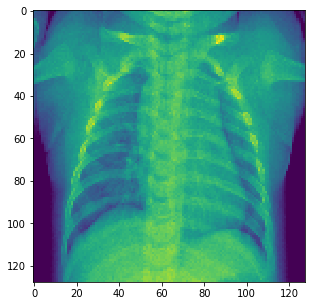

In [6]:
# Print first image of training set
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0, :].reshape(img_size, img_size))

Above is the first image within the dataset.

## RBM Modeling
RBM is a neural network that has one visible layer (input) and one hidden layer. Each neuron in its hidden layer represents a latent factor in determing the classification of the image. The learning rate was reduced to .01 to reduce the adaption of the model to the dataset. This reduces the chances of it overfitting to the data and inaccurately predicting lung condition. Two models were run: one with reduced number of components and the other with an increased amount.

### Model 1 : Reduced Components
The components of the reduced model is half of the image size squared. For the purpose of this model it is 64x64. 

In [7]:
start_time = time.time()

# n is the number of components
n = int(img_size / 2)

# Pipeline is a series of transformation that will be modeled
# RBM then logistic regression
rbm = BernoulliRBM(n_components=n*n, random_state=1, 
                   learning_rate=.01, verbose=1)

logistic = linear_model.LogisticRegression()
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Fit and train model
classifier = classifier.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -8077.05, time = 167.70s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -449.19, time = 178.91s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -460.46, time = 165.71s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -262.60, time = 179.28s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -104.17, time = 165.78s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -132.78, time = 179.22s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -125.38, time = 165.49s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -117.96, time = 184.94s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -132.51, time = 165.84s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -126.11, time = 180.32s


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
# Predict lung results
pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)
print('Test Set Predicted')

# Print results of test and train data
print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Test Set Predicted

Accuracy Score of Training Set: 0.8179487179487179

Accuracy Score of Test Set: 0.625

--- 1740.2843055725098 seconds ---


#### Model Results
The training group performed well at 81.8% accuracy. The test group however performed poorly at 62.5%, which indicates an overfit model. Looking at the confusion matrix below, there does not seem to be any bias in the model towards healthy or unheathly. Most likely the issue is that the model lacks complexity due to the smaller number of neurons.

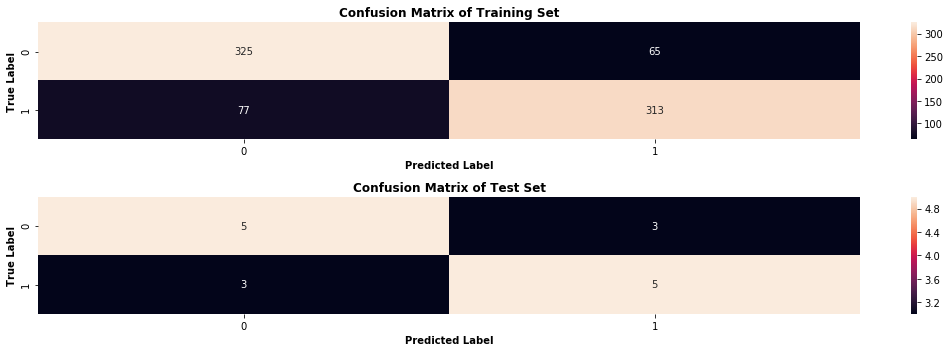

In [9]:
# create heatmap of confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

### Model 2 : Increased Components
As pointed out above, model one suffered from overfitment mostly likely due to lack of complexity. For model 2, the complexity will be increased by squaring the img size ie. 128x128. This model will take longer to run, but hopefully will provide better results. See the Summary and conclusion section for the analysis of the performance of model 2. 

In [11]:
start_time = time.time()

# Pipeline is a series of transformation that will be modeled
# RBM then logistic regression
rbm = BernoulliRBM(n_components=img_size*img_size, 
                   random_state=1, learning_rate=.01, verbose=1)

logistic = linear_model.LogisticRegression()
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Fit and train model
classifier = classifier.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -144.86, time = 786.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.55, time = 814.53s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -128.09, time = 830.97s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -126.65, time = 840.31s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -130.67, time = 825.25s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -143.92, time = 823.99s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -139.60, time = 815.94s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -126.81, time = 824.43s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -118.91, time = 855.44s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -137.75, time = 833.65s


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
# Predict lung results
pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)
print('Test Set Predicted')

# Print results of test and train data
print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Test Set Predicted

Accuracy Score of Training Set: 0.8141025641025641

Accuracy Score of Test Set: 0.8125

--- 8285.022778272629 seconds ---


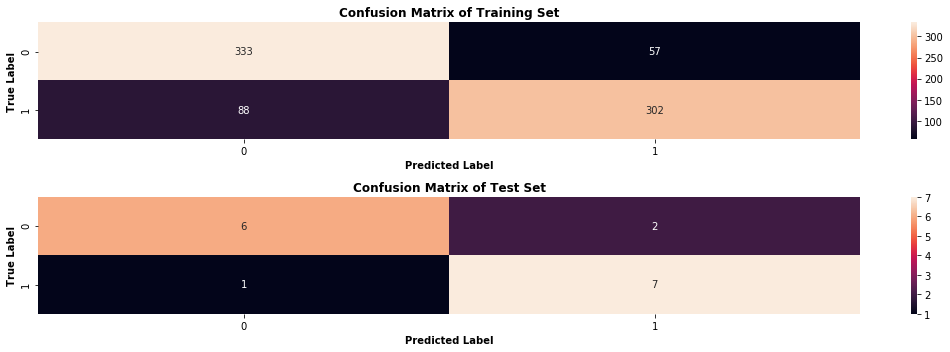

In [13]:
# create heatmap of confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

Below is plotted the first 200 components of the rbm model.

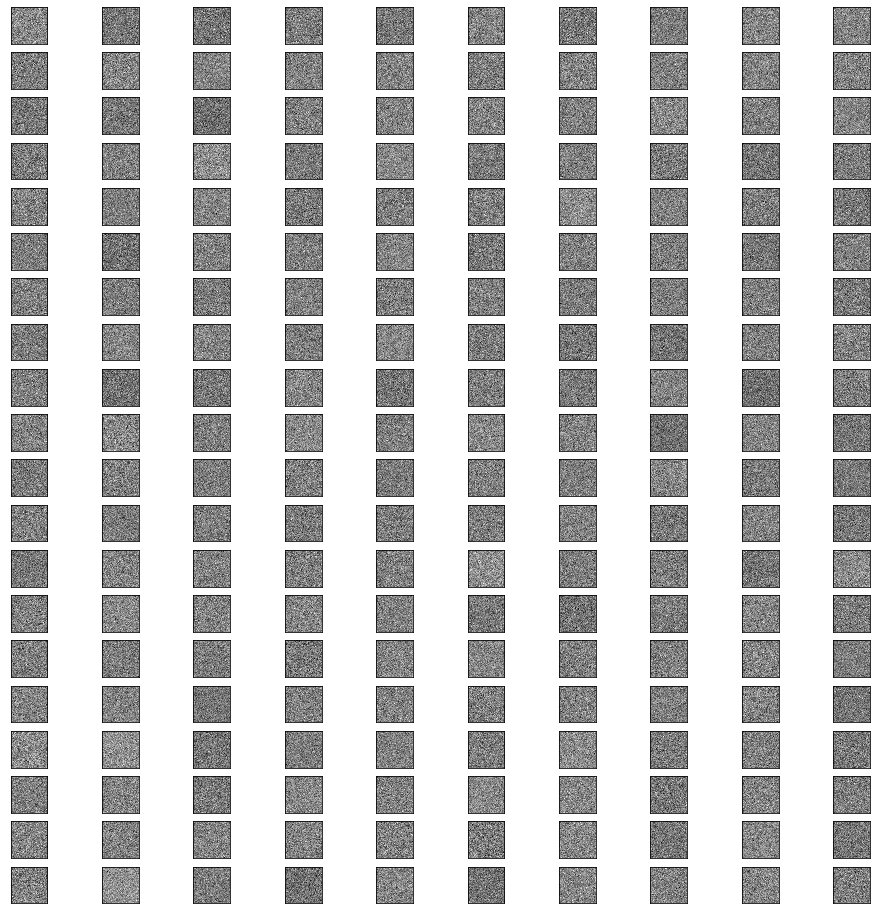

In [15]:
# Plot the first 200 rbm components for visalization
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_[:200]):
    plt.subplot(20, 10, i + 1)
    plt.imshow(comp.reshape((128,128)), cmap=plt.cm.gray_r,
        interpolation='nearest')    
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

## Summary and Conclusion
The goal of this challenge was to create a RBM model that process images reasonably well based on the resuts above. Model 2 performed much better than model 1. It had an 81.4% accuracy in the training set and an 81.25% accuracy on the test set. While the accuracy was not in the high 90s, the model was not overfit. 

There are several ways to improve the dataset further. One could decrease the learning rate to see how much the accuracy changes by. Another idea is to implement PCA to reduce the dimensionality of the data and feed even more images to the model. Last, the complexity of the model could be increased by increasing the number of components further. 

Overall this was a great dataset to explore RBM, and imaging processing.